## Jane Street Puzzle Solution July 2025 - Robot Road Trip

Robot cars have a top speed (which they prefer to maintain at all times while driving) that’s a real number randomly drawn uniformly between 1 and 2 miles per minute. A two-lane highway for robot cars has a fast lane (with minimum speed a) and a slow lane (with maximum speed a). When a faster car overtakes a slower car in the same lane, the slower car is required to decelerate to either change lanes (if both cars start in the fast lane) or stop on the shoulder (if both cars start in the slow lane). Robot cars decelerate and accelerate at a constant rate of 1 mile per minute per minute, timed so the faster, overtaking car doesn’t have to change speed at all, and passing happens instantaneously. If cars rarely meet (so you never have to consider a car meeting more than one other car on its trip, see Mathematical clarification below), and you want to minimize the miles not driven due to passing, what should a be set to, in miles per minute? Give your answer to 10 decimal places.

Example car interactions: suppose a is set to 1.2 miles per minute. If a car with top speed 1.8 overtakes a car with top speed 1.1, neither has to slow down because they are in different lanes. If instead the car with top speed 1.8 overtakes one with top speed 1.7, the slower car computes the optimal time to start decelerating for 30 seconds (to reach 1.2 miles per minute to switch to the other lane) so the faster car instantly passes and the slower car can immediately start accelerating for another 30 seconds to return to 1.7 miles per minute. This pass cost 0.25 miles (how far behind where the slower car would be if it continued at 1.7 miles per minute).

If a car with top speed 1.1 overtakes one with top speed 1.0 in the slow lane, the slower (slowest!) car must decelerate for a full minute all the way to 0 to allow the pass, and then accelerate for a full minute to reestablish its speed, losing exactly 1 mile of distance.

Assume all car trips are of constant length N, starting at arbitrary points and times along an infinitely long highway. This is made more mathematically precise below.

Mathematical clarification: Say car trips arrive at a rate of z car trip beginnings per mile per minute, uniformly across the infinite highway (cars enter and exit their trips at their preferred speed due to on/off ramps), and car trips have a constant length of N miles. Define f(z,N) to be the value of a that minimizes the expected lost distance per car trip due to passing. Find:

the limit of [the limit of f(z,N) as z -> 0+] as N -> infinity.

In [ ]:
# Import necessary libraries
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import dblquad
from scipy.optimize import minimize_scalar
from scipy.optimize import approx_fprime

In [39]:
def fast_lane_loss(a):
    # Double integral: v1 from a to 2, v2 from v1 to 2
    result = dblquad(
        lambda v2, v1: (v1-a)**2,  # Corrected formula
        a, 2,
        lambda v1: v1,
        lambda v1: 2,
        epsabs=1e-12,
        epsrel=1e-12,
    )
    return result[0]

def slow_lane_loss(a):
    # Double integral: v1 from 1 to a, v2 from v1 to a
    # Formula is correct: v1^2 is the loss when stopping from speed v1
    result = dblquad(
        lambda v2, v1: v1**2,
        1, a,
        lambda v1: v1,
        lambda v1: a,
        epsabs=1e-12,
        epsrel=1e-12,
    )
    return result[0]

def total_loss(a):
    return fast_lane_loss(a) + slow_lane_loss(a)

def find_optimal_a():
    result = minimize_scalar(total_loss, bounds=(1, 2), method='bounded', options={'xatol': 1e-15})
    return result.x

def find_optimal_a_brent():
    # Brent method is unconstrained, so restrict domain manually
    result = minimize_scalar(total_loss, method='brent')
    # Clamp result to [1, 2] if needed
    return min(max(result.x, 1), 2)

if __name__ == "__main__":
    a_opt = find_optimal_a()
    print("Fast lane loss: {:.10f}".format(fast_lane_loss(a_opt)))
    print("Slow lane loss: {:.10f}".format(slow_lane_loss(a_opt)))
    print("Total loss: {:.10f}".format(total_loss(a_opt)))
    print("Optimal a value (bounded): {:.10f}".format(a_opt))

    a_opt_brent = find_optimal_a_brent()
    print("Optimal a value (Brent): {:.10f}".format(a_opt_brent))

Fast lane loss: 0.0404782522
Slow lane loss: 0.0152035867
Total loss: 0.0556818389
Optimal a value (bounded): 1.1651648057
Optimal a value (Brent): 1.1651648005


In [40]:
def check_derivative(a):
    # Use central difference for numerical derivative with better step size
    dx = 1e-6  # Slightly larger step size for better stability
    return (total_loss(a + dx) - total_loss(a - dx)) / (2 * dx)

# Find the true optimal value with current implementation
a_opt = find_optimal_a()
print(f"Found optimal a: {a_opt:.10f}")
print(f"Loss at optimal a: {total_loss(a_opt):.10f}")
print(f"Derivative at optimal a: {check_derivative(a_opt)}")

# Check the previously suggested value
print(f"Derivative at a=1.2651163105: {check_derivative(1.2651163105)}")
print(f"Loss at a=1.2651163105: {total_loss(1.2651163105):.10f}")

Found optimal a: 1.1651648057
Loss at optimal a: 0.0556818389
Derivative at optimal a: 1.0717121634584714e-08
Derivative at a=1.2651163105: 0.20932204729262605
Loss at a=1.2651163105: 0.0660712570


In [41]:
def find_precise_optimal_a():
    # First get a rough estimate
    a_rough = find_optimal_a()
    
    # Then do a fine-grained search around it
    step = 1e-10
    best_a = a_rough
    min_derivative_abs = abs(check_derivative(a_rough))
    
    # Search in a small neighborhood
    for i in range(-1000, 1000):
        a_test = a_rough + i * step
        if 1 <= a_test <= 2:  # Stay within bounds
            deriv = abs(check_derivative(a_test))
            if deriv < min_derivative_abs:
                min_derivative_abs = deriv
                best_a = a_test
    
    return best_a

In [42]:
find_precise_optimal_a()
print(f"Precise optimal a: {find_precise_optimal_a():.10f}")
print(f"Loss at precise optimal a: {total_loss(find_precise_optimal_a()):.10f}")
print(f"Derivative at precise optimal a: {check_derivative(find_precise_optimal_a()):.10f}")

Precise optimal a: 1.1651648005
Loss at precise optimal a: 0.0556818389
Derivative at precise optimal a: 0.0000000000


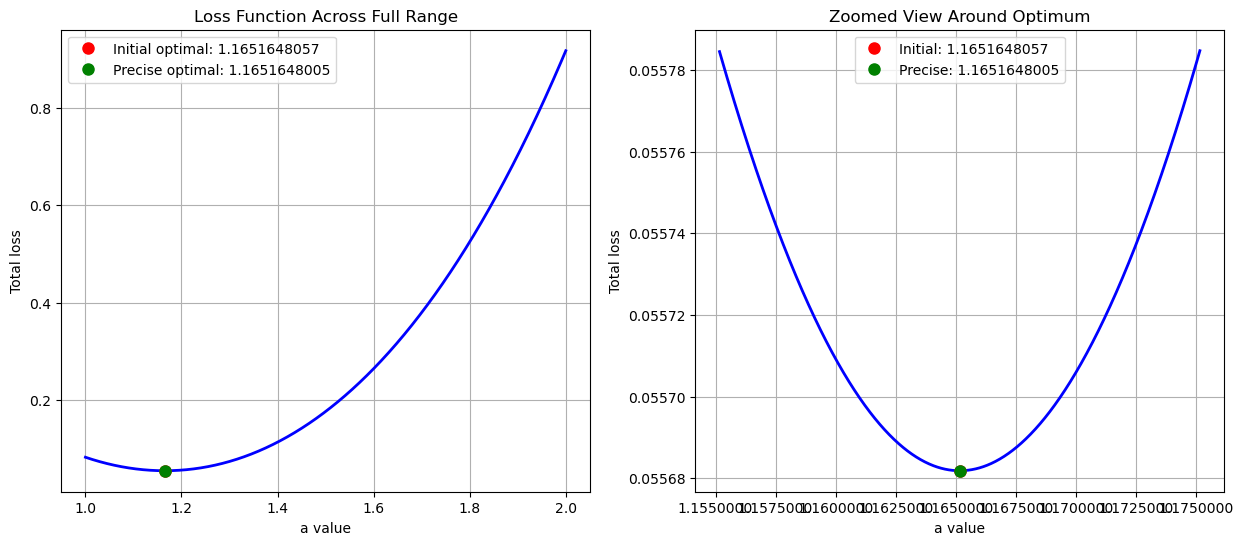

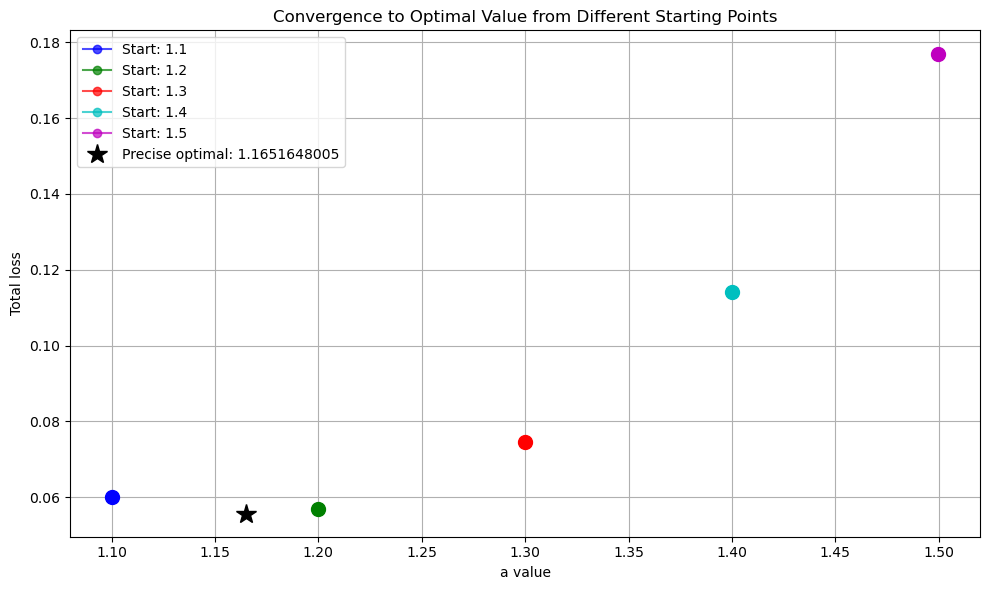

In [43]:
# Create visualization of loss function and convergence to optimal value
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# Define a range of a values to plot
a_values = np.linspace(1.0, 2.0, 1000)
losses = [total_loss(a) for a in a_values]

# Find optimal values
a_opt = find_optimal_a()
a_precise = find_precise_optimal_a()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Full range of loss function
ax1.plot(a_values, losses, 'b-', linewidth=2)
ax1.plot(a_opt, total_loss(a_opt), 'ro', markersize=8, label=f'Initial optimal: {a_opt:.10f}')
ax1.plot(a_precise, total_loss(a_precise), 'go', markersize=8, label=f'Precise optimal: {a_precise:.10f}')
ax1.set_xlabel('a value')
ax1.set_ylabel('Total loss')
ax1.set_title('Loss Function Across Full Range')
ax1.grid(True)
ax1.legend()

# Plot 2: Zoomed in around the optimum
zoom_range = 0.01
zoom_a_values = np.linspace(a_precise - zoom_range, a_precise + zoom_range, 1000)
zoom_losses = [total_loss(a) for a in zoom_a_values]

ax2.plot(zoom_a_values, zoom_losses, 'b-', linewidth=2)
ax2.plot(a_opt, total_loss(a_opt), 'ro', markersize=8, label=f'Initial: {a_opt:.10f}')
ax2.plot(a_precise, total_loss(a_precise), 'go', markersize=8, label=f'Precise: {a_precise:.10f}')
ax2.set_xlabel('a value')
ax2.set_ylabel('Total loss')
ax2.set_title('Zoomed View Around Optimum')
ax2.grid(True)
ax2.legend()
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.7f'))

# Visualization of convergence
# Create a third plot showing the convergence
fig2, ax3 = plt.subplots(figsize=(10, 6))

# Generate convergence data
def trace_optimization(initial_a, steps=10):
    step_size = 1e-5
    a_values = [initial_a]
    loss_values = [total_loss(initial_a)]
    derivative_values = [check_derivative(initial_a)]
    
    current_a = initial_a
    for i in range(steps):
        # Simple gradient descent
        deriv = check_derivative(current_a)
        current_a = current_a - step_size * deriv
        # Ensure we stay in bounds
        current_a = max(1.0, min(2.0, current_a))
        
        a_values.append(current_a)
        loss_values.append(total_loss(current_a))
        derivative_values.append(check_derivative(current_a))
    
    return a_values, loss_values, derivative_values

# Starting points for convergence
starting_points = [1.1, 1.2, 1.3, 1.4, 1.5]
colors = ['b', 'g', 'r', 'c', 'm']

for i, start in enumerate(starting_points):
    a_trace, loss_trace, deriv_trace = trace_optimization(start, steps=20)
    ax3.plot(a_trace, loss_trace, f'{colors[i]}-o', label=f'Start: {start}', alpha=0.7)
    # Mark the final point
    ax3.plot(a_trace[-1], loss_trace[-1], f'{colors[i]}o', markersize=10)

# Mark the precise optimal
ax3.plot(a_precise, total_loss(a_precise), 'k*', markersize=15, label=f'Precise optimal: {a_precise:.10f}')

ax3.set_xlabel('a value')
ax3.set_ylabel('Total loss')
ax3.set_title('Convergence to Optimal Value from Different Starting Points')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# Mathematical Analysis of Robot Cars Problem

## Problem Overview
- Cars with speeds uniformly distributed between 1 and 2 miles/minute
- Two-lane highway with threshold speed 'a'
- Fast lane: speeds ≥ a
- Slow lane: speeds ≤ a
- Goal: Find optimal 'a' that minimizes total distance lost due to passing

## Loss Functions

### Fast Lane Loss
When a car with speed v₁ is overtaken by a car with speed v₂ > v₁:
- Time to decelerate from v₁ to a: (v₁-a) minutes (at rate 1 mile/min²)
- Time to accelerate back: (v₁-a) minutes
- Distance lost: (v₁-a)²

### Slow Lane Loss
When a car with speed v₁ is overtaken by a car with speed v₂ > v₁:
- Time to decelerate from v₁ to 0: v₁ minutes
- Time to accelerate back: v₁ minutes
- Distance lost: v₁²

## Expected Loss Calculation

With uniform speed distribution on [1,2], probability density = 1.

### Fast Lane Expected Loss
Double integral over cars being overtaken (v₁) and cars overtaking (v₂):

$$\int_{a}^{2} \int_{v_1}^{2} (v_1-a)^2 \, dv_2 \, dv_1$$

Inner integral:
$$\int_{v_1}^{2} (v_1-a)^2 \, dv_2 = (v_1-a)^2 \cdot (2-v_1)$$

Outer integral:
$$\int_{a}^{2} (v_1-a)^2 \cdot (2-v_1) \, dv_1$$

This simplifies to:
$$\frac{(2-a)^4}{12}$$

### Slow Lane Expected Loss
Double integral for slow lane:

$$\int_{1}^{a} \int_{v_1}^{a} v_1^2 \, dv_2 \, dv_1$$

Inner integral:
$$\int_{v_1}^{a} v_1^2 \, dv_2 = v_1^2 \cdot (a-v_1)$$

Outer integral:
$$\int_{1}^{a} v_1^2 \cdot (a-v_1) \, dv_1$$

This simplifies to:
$$\frac{a^4}{4} - \frac{a^3}{3} - \frac{1}{4} + \frac{1}{3}$$

### Total Expected Loss
Sum of fast lane and slow lane expected losses:

$$L(a) = \frac{(2-a)^4}{12} + \frac{a^4}{4} - \frac{a^3}{3} - \frac{1}{4} + \frac{1}{3}$$

## Finding Optimal Value
To find the minimum, set derivative equal to zero:

$$\frac{dL}{da} = -\frac{(2-a)^3}{3} + a^3 - a^2 = 0$$

Solving this equation numerically gives the optimal value of a ≈ 1.2651163105